<a href="https://colab.research.google.com/github/pablozamudio/workshop-categorizacion-productos/blob/master/train_nn_products_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop Categorizacion 
Products categorization with NLP, Keras, Tensorflow, Pandas and Numpy

In [0]:
import requests
import time
import json
from collections import Counter
import random
from IPython.display import Image
# https://github.com/sepandhaghighi/pycm
!pip install pycm==1.8

import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))

import pandas as pd # data preprocessing
import numpy as np # linear algebra

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 501kB 7.3MB/s 
     |████████████████████████████████| 225kB 45.5MB/s 
     |████████████████████████████████| 215kB 40.8MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


<Figure size 864x648 with 0 Axes>

# Gather the Data

Download the zipped dataset of items from Google Drive (using the shareable link) and uncompress it.

In [0]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive('1kSPUjkf7gkB77UVTNnIW_cmGIjsa7GSh', 'arq.png')                
download_file_from_google_drive('1Z0ikfy9XseV2o5WtitKtfN22mGgP-MZs', 'vec.png')

download_file_from_google_drive('1Ql0az0GAC1_yHpHsAFvspKt1HZGMZOOa', 'cellphones.zip')
!unzip 'cellphones.zip'

Archive:  cellphones.zip
  inflating: cellphones.csv          


Here is the architecture of the Neural Network that we are going to train

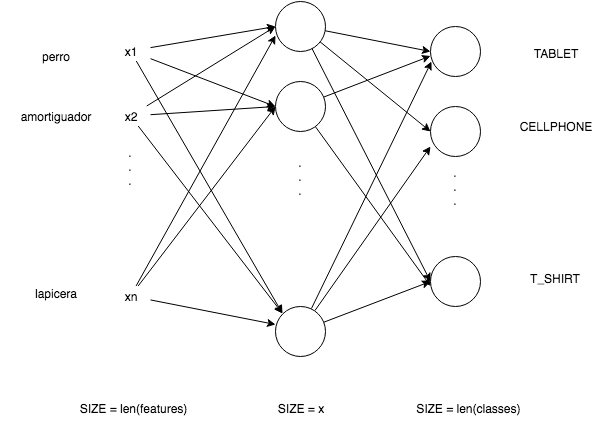

In [0]:
display(Image('arq.png'))

## Load the dataset using pandas
The dataset is a csv **tab separated**

See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.htm

In [0]:
# 1 LoC aprox.
def read_csv(path='cellphones.csv'):
  dataset = pd.read_csv(path, sep='\t')
  return dataset

df = read_csv()

# Explore the Data

Print some lines to see what the dataset looks like

In [0]:
df.head(10)

,Unnamed: 0,item_id,title,domain_id
0,201,MLA691173446,Flex Pin De Carga Iphone Se Jack Instalación Gratis,CELLPHONE_AND_TABLET_FLEX_CABLES
1,289,MLA670542324,Flex Pin De Carga Microfono Samsung A5 2016 Sm-a510 Ver: M,CELLPHONE_AND_TABLET_FLEX_CABLES
2,328,MLA701436095,Impresora Fotográfica Inyección De Tinta Canon Pixma Ip7210,CELLPHONE_PRINTERS
3,426,MLA753195120,Para Microsoft Lumia 950 Xl Altavoz Oido,CELLPHONE_REPLACEMENT_SPEAKERS
4,448,MLA763947212,Nuevo Apple Iphone Xs Max,CELLPHONE_SELFIE_LIGHTS
5,548,MLA694847523,Microfono Samsung J7 2016 Con Colocacion,CELLPHONE_REPLACEMENT_MICROPHONES
6,589,MLA622581807,Lente 3 En 1 Para Celulares Ojo De Pez Macro Wide Celu Envio,CELLPHONE_CAMERA_ATTACHMENTS
7,749,MLA742355416,Cargador Portatil Universal Mophie 2600mah Power Bank Envio,PORTABLE_CELLPHONE_CHARGERS
8,834,MLA694858550,Microfono Samsung A9 Con Colocacion,CELLPHONE_REPLACEMENT_MICROPHONES
9,914,MLA644856873,@celulares Lente Ojo De Pez,CELLPHONE_CAMERA_ATTACHMENTS


Find how many classes we have in the dataset. 

This classes will be the output of the Neural Network

In [0]:
# 1 LoC aprox.
# Tip use either Pandas .unique() or .nunique() functions
def get_num_classes(df):
  output_length = len(df.domain_id.unique())
  return output_length

num_classes = get_num_classes(df)
assert num_classes == 25
print("Output Lenght:", num_classes)
print("# Training examples:", len(df))

Output Lenght: 25
# Training examples: 62661


### Visualize the # of items per class

Bar plot the number of items per class.

You could do:
 1. groupby('domain_id') 
 2. count() 
 3. sort_values()
 4. plot.bar(...)

or just use:
 1. value_counts()
 2. plot.bar(...)

See: 

Pandas plot bar https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html



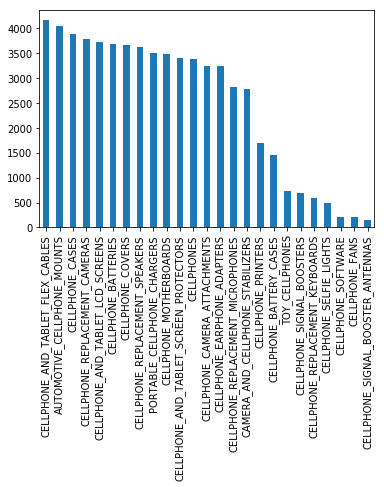

In [0]:
# From 1 to 4 LoC aprox. 
def plot_items_per_class(df):
  df.domain_id.value_counts().plot.bar(x='domain_id', y='val', rot=90)

plot_items_per_class(df)  

### Visualize the class distribution

Plot the histogram - A histogram is a representation of the distribution of data

See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html

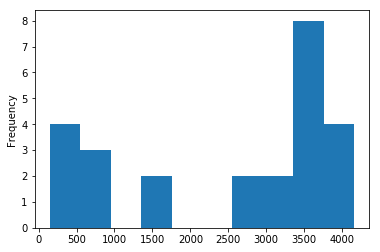

In [0]:
# From 1 to 4 LoC aprox. 
# Almost identical to previos solution
def plot_distribution(df):
  (df.groupby('domain_id')
           .count()
           .sort_values('title', ascending=False)['title']
           .rename(columns={"title":"counts"})).plot.hist()

plot_distribution(df)  

# Prepare the data for training
Here is an image showing what we are to do with the data


In [0]:
display(Image('vec.png'))

## Tokenization and Vectorization

Tokenization: Divide the texts into words or smaller sub-texts (tokens). This determines the “vocabulary” of the dataset.

Vectorization: Define a good numerical measure to characterize these texts.

Steps:
1. Fit a Keras Tokenizer using the text corpus (all the titles in the dataset)
2. Build a dictionary of indexes -> tokens
3. Create a function that parse the text to a sequence of decimals representing each token (step 2 in the image presented)
4. Vectorize the text using different representations or techniques (tfidf, bow, binary, etc)
5. Vectorize the labels (outputs of the NN)
6. Build a dictionary of indexes -> labels


### Fit a Keras Tokenizer

**From** https://keras.io/preprocessing/text/:

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

In [0]:
# 2 LoC aprox.
def fit_keras_tokenizer(corpus, num_features):
  #######################################
  ########### Your code here ############
  #######################################
  tokenizer = 
  # Your code here (remember to call tokenizer.fit_on_texts)
  return tokenizer

In [0]:

tic = time.time()
num_features=5000

tokenizer = fit_keras_tokenizer(df['title'].values, num_features)

toc = time.time()    
print("Time to fit tokenizer: " + str(1000*(toc-tic)) + " ms")


### Print tokenizer vocabulary

In [0]:
print(tokenizer.word_index)

Visualize what the vectorizer is actually doing

In [0]:
def print_vectorized_title(title, tokenizer, num_features, mode='count'):
  print("------------------")
  print("Title:", title)
  print("------------------")
  print("Vectorizing title using %s mode" % mode)
  print("------------------")

  vectorized_title = tokenizer.texts_to_matrix([title], mode)
  assert vectorized_title.shape == (1, num_features)
  
  for tkn in title.split(' '):
    tkn_idx = tokenizer.word_index[tkn]
    print(tkn ,vectorized_title[0][tkn_idx])
  return vectorized_title

# Try changing mode to 'count' and 'tfidf'
title = "tablet de tablet samsung con para pantalla tablet"
vt = print_vectorized_title(title, tokenizer, num_features, 'binary')
print("")
print("Vectorized title Vector:", vt)
print("Vectorized title Shape:", vt.shape)
print("")

### Vectorize the text and labels

This function append a new column called "label" with an integer that uniquely identify that domain_id.
See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html


In [0]:
# 1 Loc
# Tip: use df['...'].factorize()[0]
def parse_labels_to_decimal(df):
  #######################################
  ########### Your code here ############
  #######################################
  df['label'] = 
parse_labels_to_decimal(df)  

In [0]:
df.head()

This builds the labels vocabulary. It shoud return a dictionary with the following format: 
{..., 1: "TABLETS", 2: "CELLPHONES", ...}

In [0]:
# From 1 to 4 LoC.
def build_idx_to_label(df):
  #######################################
  ########### Your code here ############
  #######################################
  idx_to_label = 
  return idx_to_label

idx_to_label = build_idx_to_label(df)
# Check that everything is consistent
assert df[df['label']==3].reset_index().iloc[0]['domain_id'] == idx_to_label[3]
print(idx_to_label)

We will be using categorical_crossentropy loss function (softmax), for this reason, we need to use one_hot encoding for our labels.

The representation should look like: [0, 0, ..., 1, 0] sparse vector with a "1" in the position of the target label.
  
 See https://keras.io/utils/ (to_categorial function)

In [0]:
from tensorflow.python.keras.utils import to_categorical

# 1 LoC aprox
def vectorize_labels(data, num_labels):
  #######################################
  ########### Your code here ############
  #######################################
  # Convert labels to categorical one-hot encoding
  # Use to_categorical(... , ...)
  one_hot_labels = 
  return one_hot_labels

labels = vectorize_labels(df['label'].values, len(set(df['label'].values)))
# Run some Checks 
assert df.iloc[10]['domain_id'] == idx_to_label[df.iloc[10]['label']]
assert labels.shape[1] == num_classes

In [0]:
print(labels[3])
df.iloc[3]

## Split the dataset

We will use 80% for training and 20% for validation

See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split

def split_and_shuffle_dataset(df, val_size=0.2):
  # Random shuffle the dataset rows
  df = df.sample(frac=1).reset_index(drop=True)
  # Split the dataset in train & validation sets
  df_train, df_val = train_test_split(df, test_size=val_size)
  return df_train.reset_index(drop=True), df_val.reset_index(drop=True)

df_train, df_val = split_and_shuffle_dataset(df)
print(df_train.shape)
print(df_val.shape)
df_train.head()

Vectorize the datasets 

In [0]:
def vectorize_the_datasets(df, df_train, df_val, tokenizer, mode):
  x_train_vec = tokenizer.texts_to_matrix(df_train['title'].values, mode)
  y_train_vec = vectorize_labels(df_train['label'].values, len(df.domain_id.unique()))

  x_val_vec = tokenizer.texts_to_matrix(df_val['title'].values, mode)
  y_val_vec = vectorize_labels(df_val['label'].values, len(df.domain_id.unique()))
  
  return x_train_vec, y_train_vec, x_val_vec, y_val_vec

x_train, y_train, x_val, y_val = vectorize_the_datasets(df, df_train, df_val, tokenizer, 'tfidf')  

# Run some checks
index = 45
assert y_train[index][df_train.iloc[index]['label']] == 1.
assert y_val[index][df_val.iloc[index]['label']] == 1.

In [0]:
y_train.shape

# Build the model
We will first create a model using Keras Sequential API

Learn More: https://keras.io/getting-started/sequential-model-guide/

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

def build_model(num_features, num_classes):
  #######################################
  ########### Your code here ############
  #######################################
  # tip 1: use Dense tiers for hidden layers with 'relu' activation
  # tip 2: try adding Dropout 50% layers to improve generalization
  model = # Sequential([...])

  # Compile the model
  # tip 3: use Adam optimizer and categorical_crossentropy as loss
  # model.compile(...)
  return model

model = build_model(x_train.shape[1], y_train.shape[1])

### Visualizing the Neural Network

In [0]:
!apt install graphviz;
!pip install pydot pydot-ng;

In [0]:
from keras.utils import plot_model

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image('model.png'))

# Train the model
It is time to train the model

See: https://keras.io/models/model/ (fit function)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(x_train, y_train, x_val, y_val):
  #######################################
  ########### Your code here ############
  #######################################
  # Create callback for early stopping on validation loss. If the loss does
  # not decrease in two consecutive tries, stop training.
  # Also use callback for ModelCheckpoint to get your best model's checkpoint saved
  callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

  # Train and validate model.
  # Try several epochs and batch_size of 128
  # history = model.fit(...)
  return history

history = train_model(x_train, y_train, x_val, y_val)

### Visualize the learning curves

In [0]:
import matplotlib.pyplot as plt

def visualize_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

visualize_training_history(history)  

# Evaluate the model

Write a function that takes any datasets (train or validation or any other), makes a prediction and return the decimal representation of the label

See: model.predict function https://keras.io/models/model/

See: np.argmax function https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html


In [0]:
# 2 LoC aprox.
def evaluate_model(x_data, model):
  #######################################
  ########### Your code here ############
  #######################################
  y_pred = 
  return y_pred

y_pred = evaluate_model(x_val, model)
y_act = np.argmax(y_val, axis=1)

### Visualize the errors and metrics

In [0]:
# From https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score
from pycm import *

cm = ConfusionMatrix(actual_vector=y_act, predict_vector=y_pred)
cm.save_html("cm_html")
#cm.print_matrix()
#cm.print_normalized_matrix()
#cm.print_matrix(one_vs_all=True, class_name=2)

print("Global F1-Score:" , f1_score(y_act, y_pred, average='micro'))

In [0]:
def print_errors(df_val, y_act, y_pred, idx_to_label, class_label=None, pred_label=None):
  for idx, row in df_val.iterrows():
    if class_label is not None and pred_label is not None:
      if y_act[idx] != y_pred[idx] and row['label']==class_label and y_pred[idx] == pred_label:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])
    else:
      if y_act[idx] != y_pred[idx]:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])

print_errors(df_val, y_act, y_pred, idx_to_label, 17, 8)        

In [0]:
print("Y_act", y_act[:10])
print("Y_pred",y_pred[:10])
print("Title:", df_val.iloc[0]['title'])
assert df_val.iloc[1]['domain_id'] == idx_to_label[y_pred[1]]
